In [1]:
import neuro_morpho_toolbox as nmt

import os
import numpy as np
import pandas as pd
import pickle

import sklearn
from sklearn import metrics
import scipy

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import SimpleITK as sitk

sns.set(rc = mpl.rc_params())
%matplotlib inline


/Users/pengxie/Documents/Research/python/neuro_morhpo_toolbox/neuro_morpho_toolbox/
Loading CCF Atlas data...
Loading time: 0.75
Loading CCF brain structure data...
Loading time: 0.00
Loading flat_map ...
Loading time: 3.87


In [2]:
mpl.rc_params()

RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.f

In [3]:
red = np.array([255,0,0])
green = np.array([0,255,0])
blue = np.array([0,0,255])
orange = np.array([255,105,0])
purple = np.array([160,32,240])
brown = np.array([160,82,45])

## Get cell list

In [4]:
path = "/Users/pengxie/Documents/Research/Thalamus_fullMorpho/Data/swc/Mapped_Feb2021/"
group = "VPL"
target = "SSp"
tid = nmt.bs.get_all_child_id(nmt.bs.name_to_id(target))
print([nmt.bs.id_to_name(i) for i in tid])

distal_thres = 0.8
midline = nmt.annotation.micron_size['z']/2
z_max = nmt.annotation.micron_size['z']
x_max = nmt.annotation.micron_size['x']
y_max = nmt.annotation.micron_size['y']


['SSp', 'SSp1', 'SSp2/3', 'SSp4', 'SSp5', 'SSp6a', 'SSp6b', 'SSp-n', 'SSp-n1', 'SSp-n2/3', 'SSp-n4', 'SSp-n5', 'SSp-n6a', 'SSp-n6b', 'SSp-bfd', 'SSp-bfd1', 'SSp-bfd2/3', 'SSp-bfd4', 'SSp-bfd5', 'SSp-bfd6a', 'SSp-bfd6b', 'VISrll', 'VISrll1', 'VISrll2/3', 'VISrll4', 'VISrll5', 'VISrll6a', 'VISrll6b', 'SSp-ll', 'SSp-ll1', 'SSp-ll2/3', 'SSp-ll4', 'SSp-ll5', 'SSp-ll6a', 'SSp-ll6b', 'SSp-m', 'SSp-m1', 'SSp-m2/3', 'SSp-m4', 'SSp-m5', 'SSp-m6a', 'SSp-m6b', 'SSp-ul', 'SSp-ul1', 'SSp-ul2/3', 'SSp-ul4', 'SSp-ul5', 'SSp-ul6a', 'SSp-ul6b', 'SSp-tr', 'SSp-tr1', 'SSp-tr2/3', 'SSp-tr4', 'SSp-tr5', 'SSp-tr6a', 'SSp-tr6b', 'SSp-un', 'SSp-un1', 'SSp-un2/3', 'SSp-un4', 'SSp-un5', 'SSp-un6a', 'SSp-un6b']


In [5]:
[ns] = pickle.load(open("neuron_set_1741cells.pickle", 'rb'))

metadata = ns.metadata.copy()
metadata = metadata[metadata['Manually_corrected_soma_region'].isin([group])]
metadata.rename(columns={'Transgenic_line':'creline',
                         'Brain_id':'brain',     
                         'Subclass_or_type':'cluster'
                        }, inplace=True)
metadata['creline'] = [i.split('-')[0] for i in metadata['creline'].tolist()]
metadata = metadata[['brain', 'creline']]
nlist = metadata.index.tolist()

metadata.head()


,brain,creline
17302_00020,17302,Tnnt1
17302_00021,17302,Tnnt1
17302_00078,17302,Tnnt1
17302_00116,17302,Tnnt1
17545_00154,17545,Tnnt1


In [6]:
def total_length(swc):
    cswc = swc.copy()
    clist = cswc[cswc['parent'].isin(cswc.index)].index.tolist()
    plist = cswc.loc[clist, 'parent'].tolist()
    res = np.sum(np.square(np.array(cswc.loc[clist, ['x', 'y', 'z']]) - 
                           np.array(cswc.loc[plist, ['x', 'y', 'z']])), axis=1)
    res = np.sum(np.sqrt(res))
    return res

## Soma

In [7]:
soma_df = ns.features['soma_features'].raw_data.copy()
soma_df = soma_df.loc[nlist, ['x', 'y', 'z']]
soma_df.head()

,x,y,z
17302_00020,6667.55,4863.250,4084.350
17302_00021,6569.60,4656.425,4118.550
17302_00078,7424.50,4148.400,3235.650
17302_00116,7378.25,4097.925,3393.125
17545_00154,7056.40,3500.300,3699.050


## Axon

In [8]:
def get_node_regions(swc, scale=1/25):
    cswc = swc.copy()
    cswc[['x', 'y', 'z']] = cswc[['x', 'y', 'z']] * scale
    cswc[['x', 'y', 'z']] = cswc[['x', 'y', 'z']].round(0).astype(int)
    cswc['region'] = 0
    idlist = cswc[((cswc.x>0) & (cswc.x<nmt.annotation.array.shape[0]) &
                   (cswc.y>0) & (cswc.y<nmt.annotation.array.shape[1]) &
                   (cswc.z>0) & (cswc.z<nmt.annotation.array.shape[2])
                  )].index.tolist()
    cswc.loc[idlist, 'region'] = nmt.annotation.array[cswc.x, cswc.y, cswc.z]
    cswc['region'] = cswc['region'].astype(int)
    return cswc

def get_center(swc, silent=True):
    df = swc.copy()[['x', 'y', 'z']]
    distance = metrics.euclidean_distances(df)
    cid = np.argmin(np.mean(distance, axis=1))
    cid = df.index.tolist()[cid]
    # exclude outliers
    md = metrics.euclidean_distances(np.array(df.loc[cid]).reshape(1, 3), df).reshape(-1,)
    tp = df[md>1000] # define outliers
    outlier_ratio = len(tp) / len(df) * 100
    if not silent:            
        if outlier_ratio>10:
            print("%.2f%% arbor excluded." % (outlier_ratio))
    df.drop(index=tp.index, inplace=True)
    # Re-center
    distance = metrics.euclidean_distances(df)
    cid = np.argmin(np.mean(distance, axis=1))
    cid = df.index.tolist()[cid]
    return cid, outlier_ratio
 

ca = ns.neurons[nlist[0]].swc.copy()
ca['region'] = get_node_regions(ca)['region']
ca = ca[ca.region.isin(tid)]
cc, outlier_ratio = get_center(ca, False)
# cc = ca.loc[cc]
# cc

In [9]:
axon_dict = {}
nlist_selected = []
axon_df = pd.DataFrame(index=nlist, columns=['x', 'y', 'z', 'length'])
for i in nlist:
# for i in ['17545_00054']:
    cswc = ns.neurons[i].swc.copy()
    cswc = cswc[cswc.type==2]
    cswc['region'] = get_node_regions(cswc)['region']
    cswc = cswc[cswc.region.isin(tid)]
    cswc = cswc[cswc.parent.isin(cswc.index)]
    if len(cswc)>0:
        cc, outlier_ratio = get_center(cswc, True)
        cc = cswc.loc[cc]
    cl = total_length(cswc)/1000
    if cl < 1:
        print('%s:\t%.2fmm' % (i, cl))
    else:
        nlist_selected.append(i)
        axon_dict.update({i:cswc})
        axon_df.loc[i, ['x', 'y', 'z', 'length']] = cc[['x', 'y', 'z']].tolist()+[cl]

print(len(nlist), len(nlist_selected))

80 80


## distance soma v.s. axon

In [10]:
%matplotlib inline

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



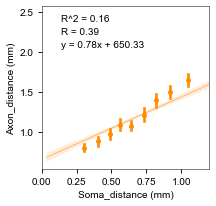

In [11]:
iu = np.triu_indices(len(nlist_selected), k=1)
soma_dist = sklearn.metrics.pairwise_distances(soma_df.loc[nlist_selected, ['x', 'y', 'z']])[iu].reshape(-1,1)
axon_dist = sklearn.metrics.pairwise_distances(axon_df.loc[nlist_selected, ['x', 'y', 'z']])[iu].reshape(-1,1)


df = pd.DataFrame({'Soma_distance (mm)':soma_dist[:,0], 
                   'Axon_distance (mm)':axon_dist[:,0],
                  })/1000

lm = sklearn.linear_model.LinearRegression()
lm.fit(soma_dist, axon_dist)
r2 = lm.score(soma_dist, axon_dist)
c1 = lm.coef_
c2 = lm.intercept_
r = np.corrcoef(soma_dist[:,0], axon_dist[:,0])[0,1]

fig, ax = plt.subplots(1,1, figsize=(3,3))
ax.tick_params(length=4, width=1, color='k')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)

g = sns.regplot("Soma_distance (mm)", "Axon_distance (mm)",
                data=df, 
                x_bins=10,
                order=1, 
                truncate=True,
                ax=ax,
                color='darkorange',
                line_kws={'lw':0.5},
                scatter_kws={'s':15},
                x_jitter=.1)
xlim = ax.get_xlim()
xr = (xlim[1]-xlim[0])
ylim = ax.get_ylim()
yr = (ylim[1]-ylim[0])
txlim = xlim[0] + xr*0.05
ax.set_xlim((0,1.2))
ax.text(txlim, ylim[0] + yr*0.95, "R^2 = %.2f" % (r2), fontdict={'ha':'left', 'va':'top'})
ax.text(txlim, ylim[0] + yr*0.87, "R = %.2f" % (r), fontdict={'ha':'left', 'va':'top'})
ax.text(txlim, ylim[0] + yr*0.79, "y = %.2fx + %.2f" % (c1, c2), fontdict={'ha':'left', 'va':'top'})

fig.savefig("../Figure/soma_axon_regression_"+group+"_v2.pdf", bbox_inches='tight')

pickle.dump([df], open("Soma_axon_distance_"+group+"_v2.pickle", 'wb'))

## Axon overlaps

Merging child region SSp into region SSp
Merging child region SSp1 into region SSp
Merging child region SSp2/3 into region SSp
Merging child region SSp4 into region SSp
Merging child region SSp5 into region SSp
Merging child region SSp6a into region SSp
Merging child region SSp6b into region SSp
Merging child region SSp-n into region SSp
Merging child region SSp-n1 into region SSp
Merging child region SSp-n2/3 into region SSp
Merging child region SSp-n4 into region SSp
Merging child region SSp-n5 into region SSp
Merging child region SSp-n6a into region SSp
Merging child region SSp-n6b into region SSp
Merging child region SSp-bfd into region SSp
Merging child region SSp-bfd1 into region SSp
Merging child region SSp-bfd2/3 into region SSp
Merging child region SSp-bfd4 into region SSp
Merging child region SSp-bfd5 into region SSp
Merging child region SSp-bfd6a into region SSp
Merging child region SSp-bfd6b into region SSp
Merging child region VISrll into region SSp
Merging child region VI

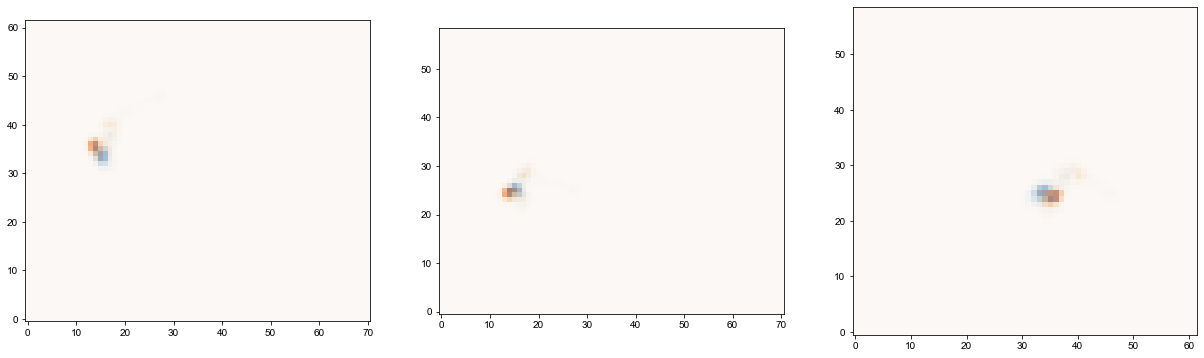

In [12]:
# Get subvolumn
region_id = nmt.bs.name_to_id(target)
tp = nmt.mergeROI([region_id], nmt.annotation.array)
tp[:,:,int(midline/25):] = 0
tp = np.where(tp==region_id)
xlim = (np.max([np.min(tp[0])*25.0 - 500, 0]), 
        np.min([np.max(tp[0])*25.0 + 500, x_max]))
ylim = (np.max([np.min(tp[1])*25.0 - 500, 0]), 
        np.min([np.max(tp[1])*25.0 + 500, y_max]))
zlim = (np.max([np.min(tp[2])*25.0 - 500, 0]), 
        np.min([np.max(tp[2])*25.0 + 500, z_max]))


print(xlim, ylim, zlim)

step_size = 75
x_steps = int((xlim[1]-xlim[0])/step_size)
y_steps = int((ylim[1]-ylim[0])/step_size)
z_steps = int((zlim[1]-zlim[0])/step_size)
print("x steps:\t%d\ny steps:\t%d\nz steps:\t%d" % (x_steps, y_steps, z_steps))

def density_estimation(cur_name, x_steps=20, y_steps=20, plot=True):
    z = axon_dict[cur_name].swc.copy()

    kde = sklearn.neighbors.KernelDensity(bandwidth=50)
    kde.fit(z[['x', 'y']])

    p = np.zeros((x_steps, y_steps))
    xs = np.linspace(xlim[0], xlim[1], num=x_steps)
    ys = np.linspace(ylim[0], ylim[1], num=y_steps)
    for i in range(x_steps):
        for j in range(y_steps):
            p[i,j] = np.exp(kde.score(np.array([xs[i], ys[j]]).reshape(1,2)))
    p = p
    p = p / np.sum(p)
    if plot:
        fig, ax = plt.subplots(1,1, figsize=(7,7))
        ax.imshow(p)
    return p

def density_estimation_3d(cur_name, x_steps=20, y_steps=20, z_steps=20, plot=True):
    z = axon_dict[cur_name].copy()

    kde = sklearn.neighbors.KernelDensity(bandwidth=50)
    kde.fit(z[['x', 'y', 'z']])

    p = np.zeros((x_steps, y_steps, z_steps))
    tp = np.where(p==0)
    tp = np.hstack([tp[0].reshape(-1,1), 
                    tp[1].reshape(-1,1),
                    tp[2].reshape(-1,1)
                   ])*step_size+np.array([xlim[0], ylim[0], zlim[0]]).reshape(1,-1)
    p = np.exp(kde.score_samples(tp)).reshape(x_steps, y_steps, z_steps, order="C")
    p = p / np.sum(p)
    
    if plot:
        fig, ax = plt.subplots(1,1, figsize=(7,7))
        ax.imshow(np.transpose(np.max(p, axis=2)), origin='lower', cmap='Reds', alpha=0.75, aspect='equal')
    return p

def get_overlap(p1, p2):
    res = np.zeros(p1.shape)
    # Calculate the frequency under curve
    lab = np.where(p1>=p2)
    res[lab] = p2[lab]
    lab = np.where(p1<p2)
    res[lab] = p1[lab]
    return np.sum(res)


# 3D version
neuron_1 = nlist[0]
neuron_2 = nlist[1]
p1 = density_estimation_3d(neuron_1, x_steps, y_steps, z_steps, False)
p2 = density_estimation_3d(neuron_2, x_steps, y_steps, z_steps, False)

print(neuron_1, neuron_2)
print(get_overlap(p1, p2))

fig, ax = plt.subplots(1,3, figsize=(21,7))
ax[0].imshow(np.transpose(np.max(p1, axis=2)), origin='lower', cmap='Blues', alpha=0.75, aspect='equal')
ax[0].imshow(np.transpose(np.max(p2, axis=2)), origin='lower', cmap='Oranges', alpha=0.5, aspect='equal')

ax[1].imshow(np.transpose(np.max(p1, axis=1)), origin='lower', cmap='Blues', alpha=0.75, aspect='equal')
ax[1].imshow(np.transpose(np.max(p2, axis=1)), origin='lower', cmap='Oranges', alpha=0.5, aspect='equal')

ax[2].imshow(np.transpose(np.max(p1, axis=0)), origin='lower', cmap='Blues', alpha=0.75, aspect='equal')
ax[2].imshow(np.transpose(np.max(p2, axis=0)), origin='lower', cmap='Oranges', alpha=0.5, aspect='equal')


## Axon overlaps v.s. Soma distance

In [13]:
p_dict = {}
for cur_name in nlist_selected[:]:
    p_dict[cur_name] = density_estimation_3d(cur_name, x_steps, y_steps, z_steps, False)

overlap_df = pd.DataFrame(index=nlist_selected, columns=nlist_selected)
for i in nlist_selected[:]:
    for j in nlist_selected[:]:
        overlap_df.loc[i,j] = get_overlap(p_dict[i], p_dict[j])

In [14]:
overlap_df

,17302_00020,17302_00021,17302_00078,17302_00116,17545_00154,18454_00068,18454_00109,18454_00148,18454_00163,18454_00166,...,18465_00226,18465_00228,18465_00233,18465_00235,18465_00238,18465_00242,18465_00305,18465_00328,18465_00347,18465_00348
17302_00020,1,0.243639,8.11248e-196,5.29866e-184,2.15972e-12,7.65864e-42,3.96048e-22,7.03297e-54,8.17789e-28,2.06704e-11,...,4.0672e-52,1.78551e-37,2.41902e-57,8.05896e-25,5.17218e-49,1.4992e-12,5.59914e-09,3.83834e-183,1.76651e-118,8.83862e-181
17302_00021,0.243639,1,1.23552e-241,5.67943e-218,4.69903e-15,3.83596e-54,5.72101e-30,1.4364e-60,5.24128e-36,1.89326e-14,...,1.16972e-95,3.99673e-82,5.51343e-110,3.19777e-47,7.62973e-62,9.09427e-18,6.46603e-15,2.00506e-202,4.5661e-151,1.61576e-193
17302_00078,8.11248e-196,1.23552e-241,1,0.000812038,8.69707e-53,9.41525e-45,4.30164e-77,8.49369e-39,2.51668e-55,3.15474e-105,...,2.10195e-32,5.81744e-37,1.81496e-20,3.48112e-65,1.34395e-29,6.35553e-84,1.35844e-45,2.00009e-58,2.21934e-09,3.30604e-56
17302_00116,5.29866e-184,5.67943e-218,0.000812038,1,1.40486e-54,6.90892e-42,3.37667e-73,1.08433e-37,6.48525e-50,3.45447e-99,...,2.75241e-34,2.62032e-39,3.19108e-24,4.81682e-61,4.36791e-31,5.87162e-80,9.84258e-38,2.05541e-74,1.52511e-13,2.99229e-73
17545_00154,2.15972e-12,4.69903e-15,8.69707e-53,1.40486e-54,1,0.0265176,0.0031583,0.00465016,0.0149659,0.00846925,...,0.000121349,0.000227682,1.84904e-07,0.0327792,0.00307893,0.00750712,0.0859916,1.48063e-39,8.06655e-22,8.58936e-45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18465_00242,1.4992e-12,9.09427e-18,6.35553e-84,5.87162e-80,0.00750712,8.28432e-07,0.0478336,1.99172e-08,0.00578329,0.444588,...,1.97977e-11,8.39675e-10,1.07327e-17,0.00102746,5.31464e-09,1,0.191173,6.87669e-73,2.10407e-41,5.16555e-71
18465_00305,5.59914e-09,6.46603e-15,1.35844e-45,9.84258e-38,0.0859916,0.00575298,0.0186017,0.00552737,0.0238593,0.119841,...,0.00592553,0.000256436,0.00249871,0.00147668,0.00220135,0.191173,1,7.22315e-61,9.50682e-16,2.13384e-60
18465_00328,3.83834e-183,2.00506e-202,2.00009e-58,2.05541e-74,1.48063e-39,1.13356e-24,7.89174e-53,2.79707e-15,1.13686e-38,3.67311e-60,...,0.169382,4.60446e-05,0.0144105,1.09171e-16,6.23771e-06,6.87669e-73,7.22315e-61,1,0.0191756,0.205337
18465_00347,1.76651e-118,4.5661e-151,2.21934e-09,1.52511e-13,8.06655e-22,1.40833e-15,1.63865e-30,3.95882e-07,2.99576e-20,1.35195e-39,...,0.0230432,0.101004,0.537511,5.36698e-09,0.000617341,2.10407e-41,9.50682e-16,0.0191756,1,0.00285804


/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



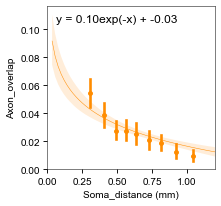

In [15]:
iu = np.triu_indices(len(nlist_selected[:]), 1)
soma_dist = sklearn.metrics.pairwise_distances(soma_df.loc[nlist_selected, ['x', 'y', 'z']])[iu].reshape(-1,1)/1000
axon_over = np.array(overlap_df)[iu].reshape(-1,1)


df = pd.DataFrame({'Soma_distance (mm)':soma_dist[:,0], 
                   'Axon_overlap':axon_over[:,0],
                   'Neuron_1':[nlist_selected[i] for i in iu[0]],
                   'Neuron_2':[nlist_selected[i] for i in iu[1]],
                  }
                 )
df = df.astype({'Soma_distance (mm)':float, 
                   'Axon_overlap':float,
                   'Neuron_1':str,
                   'Neuron_2':str,
                  }
              )


fig, ax = plt.subplots(1,1, figsize=(3,3))
ax.tick_params(length=4, width=1, color='k')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)

g = sns.regplot("Soma_distance (mm)", "Axon_overlap",
                data=df, 
                x_bins=10,
                order=1, 
                logx=True,
                truncate=True,
                ax=ax,
                color='darkorange',
                line_kws={'lw':0.5},
                scatter_kws={'s':15})
ax.set_ylim((0, ax.get_ylim()[1]))
ax.set_xlim((0,1.2))
xlim = ax.get_xlim()
xr = (xlim[1]-xlim[0])
ylim = ax.get_ylim()
yr = (ylim[1]-ylim[0])
txlim = xlim[0] + xr*0.05

lm = sklearn.linear_model.LinearRegression()
ind = df[((df['Soma_distance (mm)']>xlim[0]) & (df['Soma_distance (mm)']<xlim[1]))].index.tolist()
lm.fit(np.exp(-df.loc[ind, ['Soma_distance (mm)']]), 
       df.loc[ind, ['Axon_overlap']])
c1 = lm.coef_
c2 = lm.intercept_
# r2 = lm.score(np.exp(-df.loc[ind, ['Soma_distance (mm)']]), 
#               df.loc[ind, ['Axon_overlap']])  # coefficient of determination
# ax.text(txlim, ylim[0] + yr*0.95, "R^2 = %.2f" % (r2), fontdict={'ha':'left', 'va':'top'})
# ax.text(txlim, ylim[0] + yr*0.87, "R = %.2f" % (r), fontdict={'ha':'left', 'va':'top'})
ax.text(txlim, ylim[0] + yr*0.95, "y = %.2fexp(-x) + %.2f" % (c1, c2), fontdict={'ha':'left', 'va':'top', 'fontsize':12})


fig.savefig("../Figure/soma_axonoverlap_regression_"+group+"_v2.pdf", bbox_inches='tight')

pickle.dump([df], open("Soma_axon_overlap_"+group+"_v2.pickle", 'wb'))